# Bayesian GLMs

We've taken our first steps toward becoming Bayesian statisticians! We learned about conjugate priors, which permit exact inference for simple probabilistic models like the beta-Bernoulli model. However, we found that more complex models require some form of approximate posterior inference. MCMC methods offer a general-purpose solution to approximate inference, allowing us to construct Markov chains for which the stationary distribution is the posterior distribution of interest. Now, let's put those ideas into practice by developing MCMC algorithms for Bayesian GLMs.


## Setup

In [1]:
%%capture
!pip install jaxtyping

In [2]:
import torch
import matplotlib.pyplot as plt
from fastprogress import progress_bar

from jaxtyping import Array, Float
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Callable, Tuple
from torch.distributions import Bernoulli, Gamma, MultivariateNormal, Normal, StudentT, \
    Uniform

## Bayesian Logistic Regression

### Model

Let $y_i \in \{0,1\}$ denote a binary observation and $x_i \in \mathbb{R}^p$ a corresponding vector of covariates. Let $\beta \in \mathbb{R}^p$ denote the weights of our GLM. Our probabilistic model is,
\begin{align*}
p(y, \beta \mid X)
&= p(\beta) \prod_{i=1}^n p(y_i \mid \beta, x_i) \\
&= \mathrm{N}(\beta \mid 0, \gamma^{-1} I) \prod_{i=1}^n \mathrm{Bern}(y_i \mid f(x_i^\top \beta))
\end{align*}
where $f: \mathbb{R} \mapsto (0,1)$ is the mean function. The canonical mean function is $f(a) = \sigma(a) = 1 / (1+e^{-a})$, the logistic function, but we will consider other link functions in this lecture as well.

**Our goal** is to approximate the posterior distribution $p(\beta \mid y, X)$. Unfortuantely, the posterior doesn't have a simple closed form since the Bernoulli likelihood is not conjugate with the Gaussian prior. Instead, we will develop MCMC algorithms to draw samples from the posterior distribution, at least asymptotically.

### Generate Synthetic Data

Let's start by generating some synthetic data from a Bernoulli GLM with true weights $\beta^\star$. To make it easy to visualize, we'll use two dimensional features, so our weights will be three dimensional when we include an intercept.

In [3]:
torch.manual_seed(305 + ord('b'))

# Set constants
num_features = 3                # first "feature" is all ones
num_data = 100                  # number of data points to sample
mean_func = torch.sigmoid       # canonical mean function
prior_scale = 3.                # std of Gaussian prior \gamma^{-1/2}

# Fix true weights. Sample features, and responses.
true_weights = 1.5 * torch.tensor([0., 1., 1.])

features = torch.column_stack([
    torch.ones(num_data),
    Normal(0, 1).sample((num_data, num_features-1))
])
responses = Bernoulli(mean_func(features @ true_weights)).sample()


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


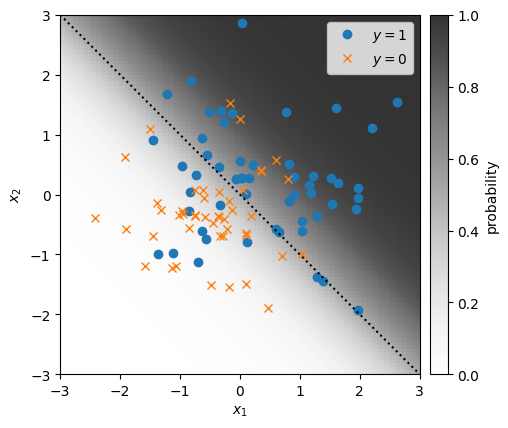

In [4]:
def plot_sample(responses: Float[Array, "num_data"],
                features: Float[Array, "num_data num_features"],
                weights: Float[Array, "num_features"],
                mean_func: Callable,
                lim=(-3, 3),
                num_points=100,
                figsize=(5, 5)
                ) -> None:
    """ Helper function to plot the samples and weights of a Bernoulli GLM.
    """
    x1, x2 = torch.meshgrid(torch.linspace(*lim, num_points),
                            torch.linspace(*lim, num_points))
    X = torch.column_stack([
        torch.ones(num_points**2),
        x1.ravel(),
        x2.ravel()
        ])
    probs = mean_func(X @ weights)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    im = plt.imshow(probs.reshape((num_points, num_points)),
                    cmap="Greys", vmin=-0, vmax=1,
                    alpha=0.8,
                    extent=lim + tuple(reversed(lim)))
    plt.plot(features[responses==1, 1], features[responses==1, 2],
             'o', markersize=6, label="$y=1$")
    plt.plot(features[responses==0, 1], features[responses==0, 2],
             'x', markersize=6, label="$y=0$")

    # Draw the true decision boundary
    x1s = torch.linspace(*lim, 100)
    x2s = -(weights[0] + weights[1] * x1s) / weights[2]
    plt.plot(x1s, x2s, ':k')

    # Clean up the axes
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.xlim(lim)
    plt.ylim(lim)
    plt.legend()

    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size="5%", pad=0.1)
    fig.add_axes(cax)
    plt.colorbar(im, cax=cax, label="probability")

plot_sample(responses, features, true_weights, mean_func)

### Log Probability

Write a function to compute the log joint probability, $p(y, \beta \mid X)$.

In [5]:
def log_joint(responses: Float[Array, "num_data"],
              features: Float[Array, "num_data num_features"],
              weights: Float[Array, "num_features"],
              mean_func: Callable,
              prior_scale: float) -> float:
    """ Compute the log joint probability of the responses and
    weights given the features. Assume the weights have a Gaussian
    prior with mean zero and the specified scale.

    Returns
    -------
    Log joint probability of the responses and weights.
    """
    lp = Normal(0, prior_scale).log_prob(weights).sum()
    lp += Bernoulli(mean_func(features @ weights)).log_prob(responses).sum()
    return lp

### Metropolis-Hastings

First, let's implement a simple Metropolis-Hasting (MH) algorithm with a symmetric Gaussian proposal distribution,
\begin{align*}
q(\beta' \mid \beta) &= \mathrm{N}(\beta' \mid \beta, \nu^2 I)
\end{align*}
where $\nu$ is the standard deviation of the proposal. This is called **random walk Metropolis-Hastings (RWMH)**.

#### Implement a single RWMH step

In [6]:
def rwmh_step(log_prob: Callable,
              curr_weights: Float[Array, "num_features"],
              curr_log_prob: float,
              proposal_scale: float) -> \
              Tuple[Float[Array, "num_features"], float]:
    """ Perform one step of random walk Metropolis-Hastings starting
    from the current weights and using a symmetric Gaussian proposal
    with the specified scale.

    Arguments
    ---------
    log_prob: a function that takes in weights and outputs an unnormalized
        log density. In our case, this function will return the log joint
        probability of the weights and responses. As a function of the weights,
        this is equal to the log posterior probability up to an unknown
        normalizing constant.
    curr_weights: the current parameters
    curr_log_prob: the current log probability (so we don't have to re-evaluate)
    proposal_scale: the standard deviation of the spherical Gaussian proposal

    Returns
    -------
    Next sample of the weights and the corresponding log prob
    """
    prop_weights = Normal(curr_weights, proposal_scale).sample()
    prop_log_prob = log_prob(prop_weights)
    accept = torch.log(Uniform(0, 1).sample()) < prop_log_prob - curr_log_prob
    return (prop_weights, prop_log_prob) if accept else (curr_weights, curr_log_prob)


#### Implement the MCMC loop

In [7]:
def rwmh(log_prob: Callable,
         init_weights: Float[Array, "num_features"],
         proposal_scale: float,
         num_iters: int = 10000,
         ) -> \
         Tuple[Float[Array, "num_samples num_features"], Float[Array, "num_samples"]]:
    """ Run the random walk MH algorithm from the given starting point and for the
    specified number of iterations.

    Returns
    -------
    Array of weight samples and corresponding log joint probabilities.
    """
    # Initialize the loop
    curr_weights = init_weights
    curr_log_prob = log_prob(curr_weights)
    weight_samples = [curr_weights]
    log_probs = [curr_log_prob]

    for itr in progress_bar(range(num_iters)):
        curr_weights, curr_log_prob = rwmh_step(log_prob,
                                                curr_weights,
                                                curr_log_prob,
                                                proposal_scale)
        weight_samples.append(curr_weights)
        log_probs.append(curr_log_prob)

    return torch.stack(weight_samples), torch.stack(log_probs)

### Let 'er rip!

In [8]:
# Make a log prob function that closes over the observations and hyperparams
log_prob = lambda weights: log_joint(responses,
                                     features,
                                     weights,
                                     mean_func,
                                     prior_scale)

# Run RWMH starting from \beta = 0
init_weights = torch.zeros(num_features)
weight_samples, log_probs = rwmh(log_prob, init_weights, proposal_scale=0.1)

### Plot the results

First look at the log joint probability as a function of MCMC iteration. It should go up and then stabilize. How does it compare to the log joint probability evaluated at the true weights, $\beta^\star$?

Text(0, 0.5, 'scaled log joint probability')

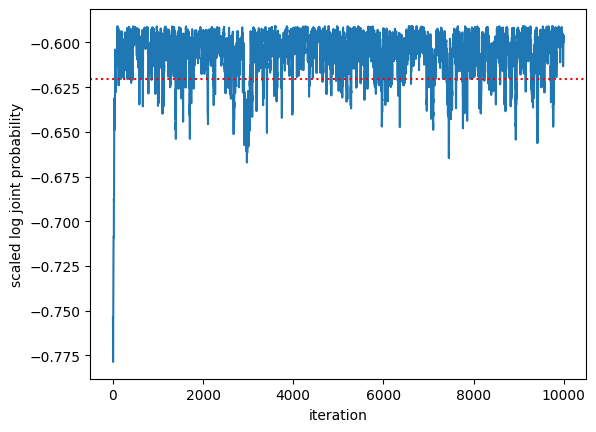

In [9]:
plt.plot(log_probs / num_data)
plt.axhline(log_prob(true_weights) / num_data, color='r', ls=':')
plt.xlabel("iteration")
plt.ylabel("scaled log joint probability")

Now make a **trace plot** of the weights acros MCMC iteration.

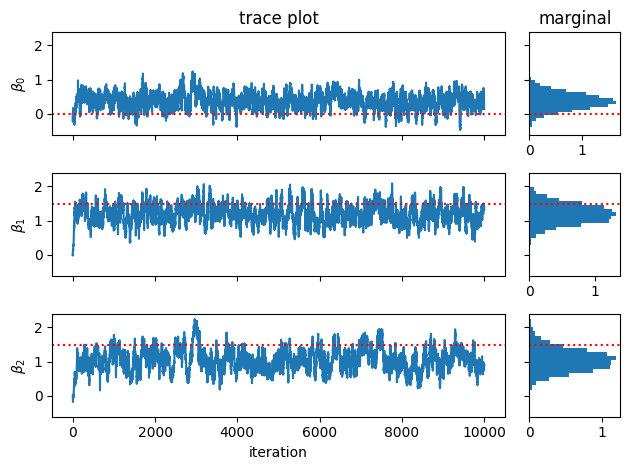

In [10]:
fig, axs = plt.subplots(num_features, 2, width_ratios=(5,1), sharey=True)
for j in range(num_features):
    # Plot the trace of the samples
    axs[j, 0].plot(weight_samples[:, j])
    axs[j, 0].axhline(true_weights[j], color='r', ls=':')
    axs[j, 0].set_ylabel(r"$\beta_{}$".format(j))
    if j < num_features - 1: axs[j,0].set_xticklabels([])

    # Plot a histogram of samples
    axs[j, 1].hist(weight_samples[:, j], 20, orientation="horizontal", density=True)
    axs[j, 1].axhline(true_weights[j], color='r', ls=':')

axs[0, 0].set_title("trace plot")
axs[0, 1].set_title("marginal")
axs[-1,0].set_xlabel("iteration")
plt.tight_layout()

Finally, let's approximate the posterior mean, $\bar{\beta}$, and plot the data and predicted probabilities under $\bar{\beta}$.

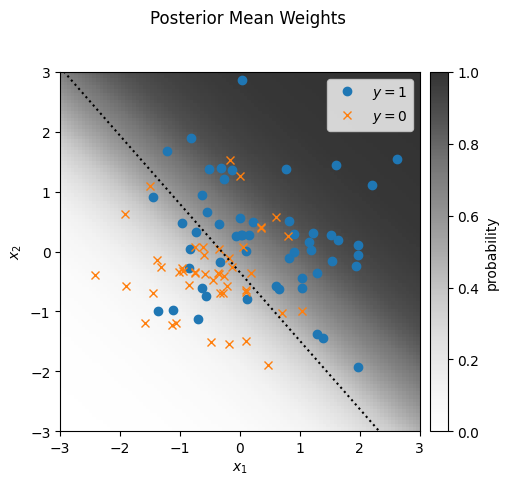

In [11]:
mean_weights = weight_samples[100:].mean(axis=0)
plot_sample(responses, features, mean_weights, mean_func)
_ = plt.suptitle("Posterior Mean Weights")

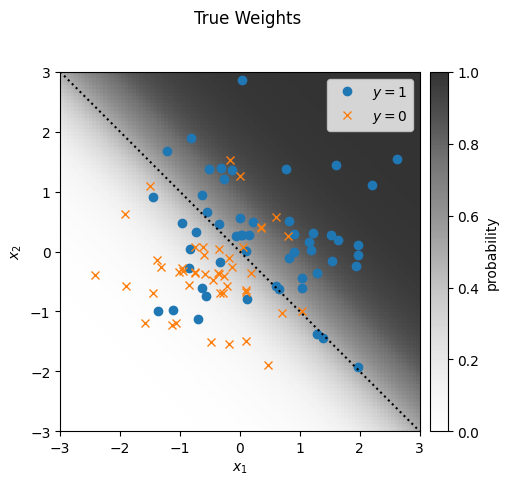

In [12]:
plot_sample(responses, features, true_weights, mean_func)
_ = plt.suptitle("True Weights")

Finally, let's look at the MCMC estimate of the posterior _pairwise_ marginal $p(\beta_1, \beta_2 \mid y, X)$ to see how correlated they are.

**Question**: Before running the cell below, do you expect the weights to be correlated under the posterior? Explain your answer.


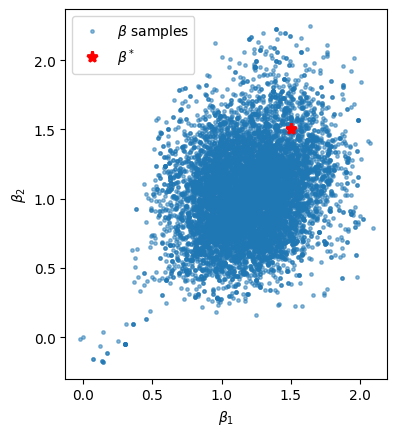

In [13]:
plt.scatter(weight_samples[:, 1], weight_samples[:, 2], s=6, alpha=0.5, label=r"$\beta$ samples")
plt.plot(true_weights[1], true_weights[2], 'r*', ms=8, mew=2, label=r"$\beta^*$")
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.legend()
plt.gca().set_aspect(1)

### Exercise

Now go back and play with the hyperparameters.
- What if you make the true weights larger &mdash; is the posterior more concentrated around the true weights?
- What happens if you change the prior variance?
- What happens if you change the proposal variance?

## Robust Bayesian Linear Regression

Now let's go on a little side quest and talk about robust linear regression. It will be a good excuse to introduce the concept of _augmentation_ and implement a Gibbs sampling algorithm. Then we'll come back to Bayesian GLMs and apply the same ideas.

### Primer: Bayesian Linear Regression with Heteroskedastic Noise

Suppose you have observations $y_i \in \mathbb{R}$ and features $x_i \in \mathbb{R}^p$. Unlike the ordinary linear regression setup, assume you have _heteroskedastic_ noise with known variance, $\sigma_i^2$ for data points $i=1,\ldots, n$.

The joint probability is,
\begin{align*}
p(y, \beta \mid X, \sigma^2)
&= p(\beta) \prod_{i=1}^n p(y_i \mid \beta, x_i, \sigma_i^2) \\
&= \mathrm{N}(\beta \mid 0, \gamma^{-1} I) \prod_{i=1}^n \mathrm{N}(y_i \mid \beta^\top x_i, \sigma_i^2)
\end{align*}

### Exercise

Derive the posterior distribution $p(\beta \mid y, X, \sigma^2)$.

#### Solution

:::{admonition} Solution
:class: dropdown
The posterior is proportional to the joint probability,
\begin{align*}
p(\beta \mid y, X, \sigma^2)
&\propto \mathrm{N}(\beta \mid 0, \gamma^{-1} I) \prod_{i=1}^n \mathrm{N}(y_i \mid \beta^\top x_i, \sigma_i^2) \\
&\propto \exp \left\{ -\frac{\gamma}{2} \beta^\top \beta \right\} \prod_{i=1}^n \frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp \left\{-\frac{1}{2 \sigma_i^2} (y_i - \beta^\top x_i)^2 \right\} \\
&\propto \exp \left\{ -\frac{1}{2} \beta^\top J \beta + h^\top \beta \right\}
\end{align*}
where
\begin{align*}
J &= \gamma I + \sum_{i=1}^n w_i x_i x_i^\top \\
h &= \sum_{i=1}^n w_i y_i x_i \\
w_i &= \frac{1}{\sigma_i^2}.
\end{align*}
We can rewrite this as a **multivariate normal distribution** by completing the square,
\begin{align*}
p(\beta \mid y, X, \sigma^2)
&\propto \exp \left\{ -\frac{1}{2} (\beta - \mu)^\top \Sigma^{-1} (\beta - \mu) \right\}
\end{align*}
where
\begin{align*}
\mu &= J^{-1} h \\
\Sigma &= J^{-1}
\end{align*}

The posterior mean can be written in terms of $x$ and $y$ in compact form,
\begin{align*}
\mu &= (\gamma I + X^\top W X)^{-1} (X^\top W y)
\end{align*}
where $W = \mathrm{diag}((w_1, \ldots, w_n))$.

We recognize this as the **weighted least squares** estimate with ridge regularization!
:::

### Robust Regression with Students' T Noise

The model above makes the strong and often unreasonable assumption that we _know the noise variance_ for each data point. A more reasonable assumption is to consider a model with heavy-tailed noise, like the following,
\begin{align*}
p(y, \beta \mid X)
&= \mathrm{N}(\beta \mid 0, \gamma^{-1} I) \prod_{i=1}^n \mathrm{St}(y_i \mid \beta^\top x_i, \sigma_0^2, \nu)
\end{align*}
where $\mathrm{St}(\mu, \sigma_0^2, \nu)$ denotes the **Students' t distribution** with mean $\mu$, scale $\sigma_0$, and $\nu$ degrees of freedom. Its density is,
\begin{align}
    \mathrm{St}(y; \mu, \sigma_0^2, \nu)
    &= \frac{\Gamma(\tfrac{\nu + 1}{2})}{\Gamma(\tfrac{\nu}{2})} \frac{1}{\sqrt{\pi \nu \sigma_0^2}} \left[1 + \frac{\Delta^2}{\nu} \right]^{-\tfrac{\nu + 1}{2}}
\end{align}
where $\Delta^2 = \left(\tfrac{y - \mu}{\sigma_0} \right)^2$ is the squared Mahalanobis distance.
Its mean is $\mu$ and its variance is $\frac{\nu}{\nu + 2} \sigma_0^2$.

Unfortunately, the Student's t distribution is not conjugate with the Gaussian prior (convince yourself).


### Student's t as a scale-mixture of Gaussians
However, here's a **nifty trick**! The Student's t density can be written as a scale-mixture of Gaussians,
\begin{align}
\mathrm{St}\left(y; \mu, \sigma_0^2, \nu \right)
&= \int \mathrm{IGa}(\sigma \mid \tfrac{\nu}{2}, \tfrac{\nu \sigma_0^2}{2}) \, \mathrm{N}(y \mid \mu, \sigma^2) \, \mathrm{d} \sigma^2
\end{align}
where $\mathrm{IGa}$ denotes the **inverse gamma distribution**, which has density
\begin{align*}
\mathrm{IGa}(\sigma^2 \mid a, b)
&= \frac{b^a}{\Gamma(a)} (\sigma^2)^{-a - 1} e^{-\frac{b}{\sigma^2}}
\end{align*}

When $a = \nu/2$ and $b = \nu \sigma_0^2 /2$, it has mean $\mathbb{E}[\sigma^2] = \frac{\nu}{\nu - 2} \sigma_0^2$ (for $\nu > 2$) and the variance shrinks as $\nu$ increases.

Notes:
- The inverse gamma is equivalent to a scaled inverse chi-squared distribution with degrees of freedom $\nu$ and scale $\sigma_0^2$.
- If $\sigma \sim \mathrm{IGa}(a, b)$ then $\sigma^{-1} \sim \mathrm{Ga}(a, b)$, so we can also think of the Student's t distribution as a continuous mixture of Gaussians with gamma distributed _precisions_.


### Augmentation Tricks

We can use the integral representation of the Student's t distribution to write our joint distribution as a marginal of an augmented model. To be precise, we can write the joint distribution above as,
\begin{align*}
p(y, \beta \mid X)
&= \mathrm{N}(\beta \mid 0, \gamma^{-1} I) \prod_{i=1}^n \mathrm{St}(y_i \mid \beta^\top x_i, \sigma_0^2, \nu) \\
&= \mathrm{N}(\beta \mid 0, \gamma^{-1} I) \prod_{i=1}^n \int \mathrm{IGa}(\sigma_i \mid \tfrac{\nu}{2}, \tfrac{\nu \sigma_0^2}{2}) \, \mathrm{N}(y_i \mid \beta^\top x_i, \sigma_i^2) \, \mathrm{d} \sigma_i^2 \\
&= \int p(y, \beta, \sigma \mid X) \, \mathrm{d}\sigma_1^2 \cdots \mathrm{d} \sigma_n^2
\end{align*}

The nice thing about Monte Carlo is that if we can draw samples from the posterior distribution of the augmented model, $p(\beta, \sigma \mid y, X)$, then we can simply discard our samples of $\sigma$ when calculating posterior expectations that are functions of $\beta$. That is,
\begin{align*}
\mathbb{E}_{p(\beta \mid y, X)} [g(\beta)]
&= \mathbb{E}_{p(\beta, \sigma^2 \mid y, X)} [g(\beta)] \\
&\approx \frac{1}{M} g(\beta^{(m)}) & \text{where} \; \beta^{(m)}, \sigma^{(m)} &\sim p(\beta, \sigma^2 \mid y, X)
\end{align*}

It may sound strictly harder to draw samples from the posterior of $\beta$ and $\sigma^2$ than from the posterior of $\beta$ alone, but that's not always the case! For example, in this augmented model, note that the conditional distributions have nice closed forms. In particular,
\begin{align*}
p(\beta \mid y, X, \sigma^2)
&\propto \mathrm{N}(\beta \mid 0, \gamma^{-1} I) \prod_{i=1}^n \mathrm{N}(y_i \mid \beta^\top x_i, \sigma_i^2).
\end{align*}
This is exactly the Bayesian linear regression model with known, heteroskedastic noise that we solved above!

#### Exercise
Derive the conditional distribution $p(\sigma_i^2 \mid y_i, x_i, \beta)$

#### Solution

:::{admonition} Solution
:class: dropdown
\begin{align*}
p(\sigma_i^2 \mid y_i, x_i, \beta) &\propto
\mathrm{IGa}(\sigma_i^2 \mid \nu/2, \nu \sigma_0^2 /2) \mathrm{N}(y_i \mid \beta^\top x_i, \sigma_i^2) \\
&\propto (\sigma_i^2)^{-(\nu + 1)/2 - 1} \exp \left\{- \frac{\nu \sigma_0^2 + (y_i - \beta^\top x_i)^2}{2 \sigma_i^2} \right\} \\
&= \mathrm{IGa}(\sigma_i^2 \mid a', b')
\end{align*}
where
\begin{align*}
a' &= \frac{\nu + 1}{2} \\
b' &= \frac{\nu \sigma_0^2 + (y_i - \beta^\top x_i)^2}{2}
\end{align*}
In other words, the inverse gamma distribution is a conjugate prior for the variance of a normal distribution (with fixed mean).
:::

### Generate Synthetic Data

Now let's generate some synthetic data from the robust linear regression model. Here, we'll use just an intercept and a slope, so $\beta \in \mathbb{R}^2$.

In [14]:
torch.manual_seed(305 + ord('b'))

# Set constants
num_features = 2                # first "feature" is all ones
num_data = 20                  # number of data points to sample
noise_scale = 1.0               # scale of the Student's t noise
noise_dof = 2.0                 # degrees of freedom of the Student's t noise
prior_scale = 3.                # std of Gaussian prior \gamma^{-1/2}

# Fix true weights. Sample features, and responses.
true_weights = torch.tensor([0., 1.])

features = torch.column_stack([
    torch.ones(num_data),
    Normal(0, 1).sample((num_data, num_features-1))
])

# Sample from a model with a mixture of Gaussians noise distribution
responses = StudentT(noise_dof, features @ true_weights, noise_scale).sample()

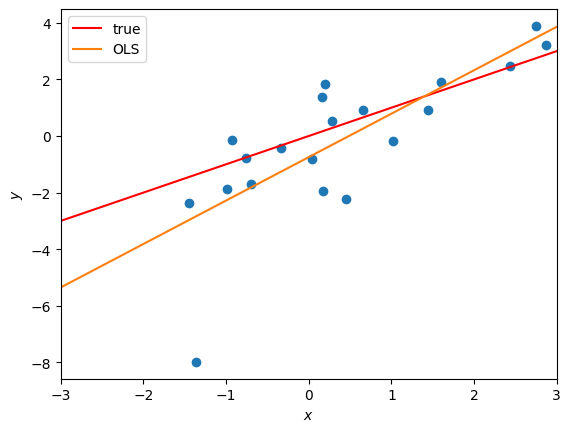

In [15]:
# Plot the data and overlay the OLS estimate of the weights
def plot_robust_reg_data(responses,
                         features,
                         true_weights,
                         weights_labels=(),
                         lim=(-3, 3)):
    plt.plot(features[:, 1], responses, 'o')
    xs = torch.linspace(*lim, 100)
    plt.plot(xs, true_weights[0] + true_weights[1] * xs, '-r', label="true")
    for weights, label in weights_labels:
        plt.plot(xs, weights[0] + weights[1] * xs, label=label)
    plt.xlim(lim)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.legend()

ols_weights = torch.linalg.solve(features.T @ features, features.T @ responses)
plot_robust_reg_data(responses, features, true_weights, [(ols_weights, "OLS")])

### Implement a Gibbs sampler

Now implement a Gibbs sampling algorithm to approximate the posterior distribution of the weights in the robust regression model. Specifically, write functions to sample the weights given noise variances and the noise variances given the weights. The Gibbs sampling algorithm will alternate between these two steps.

In [16]:
def log_joint(responses: Float[Array, "num_data"],
              features: Float[Array, "num_data num_features"],
              weights: Float[Array, "num_features"],
              prior_scale: float,
              noise_dof: float,
              noise_scale: float) -> float:
    """ Compute the log joint probability of the robust regression model """

    lp = Normal(0, prior_scale).log_prob(weights).sum()
    lp += StudentT(noise_dof, features @ weights, noise_scale).log_prob(responses).sum()
    return lp

# Test that it runs
log_joint(responses, features, true_weights, prior_scale, noise_dof, noise_scale)

tensor(-40.2235)

In [17]:
def gibbs_step_weights(responses: Float[Array, "num_data"],
                       features: Float[Array, "num_data num_features"],
                       noise_variances: Float[Array, "num_data"],
                       prior_scale: float) -> \
                       Float[Array, "num_features"]:
    """ Perform a Gibbs step to sample the weights from their conditional.

    Returns
    -------
    Next sample of the weights
    """
    num_features = features.shape[1]
    J = 1 / prior_scale**2 * torch.eye(num_features)
    J += torch.einsum("n,nj,nk->jk", 1/noise_variances, features, features)
    h = torch.einsum("n,n,nj->j", 1/noise_variances, responses, features)
    mu = torch.linalg.solve(J, h)
    return MultivariateNormal(mu, precision_matrix=J).sample()

# Test that it runs
dummy_noise_vars = torch.ones(num_data)
gibbs_step_weights(responses, features, dummy_noise_vars, prior_scale)

tensor([-1.1203,  1.7094])

In [18]:
def gibbs_step_noise_vars(responses: Float[Array, "num_data"],
                          features: Float[Array, "num_data num_features"],
                          weights: Float[Array, "num_features"],
                          noise_dof: float,
                          noise_scale: float) -> \
                          Float[Array, "num_dat"]:
    """ Perform a Gibbs step to sample the auxiliary noise variances from their conditionals.

    Note that the noise variances are conditionally independent and hence can be sampled
    in parallel.

    Returns
    -------
    Next sample of the noise variances.
    """
    concentration = 0.5 * (noise_dof + 1)
    preds = features @ weights
    rate = 0.5 * (noise_dof * noise_scale**2 + (responses - preds)**2)
    return 1 / Gamma(concentration, rate).sample()

# Test that it runs
gibbs_step_noise_vars(responses, features, true_weights, noise_dof, noise_scale)

tensor([ 0.9094,  1.2934, 49.7823,  0.8115,  2.1487,  2.4824,  0.3803, 17.6953,
         0.2016, 11.7235,  4.3357,  0.9562,  0.5754,  0.8171,  0.2200,  1.0080,
         4.2905,  2.2647,  0.6595,  0.8128])

In [19]:
def gibbs(responses: Float[Array, "num_data"],
          features: Float[Array, "num_data num_features"],
          init_weights: Float[Array, "num_features"],
          prior_scale: float,
          noise_dof: float,
          noise_scale: float,
          num_iters: int = 10000,
          ) -> \
         Tuple[Float[Array, "num_samples num_features"], Float[Array, "num_samples"]]:
    """ Run the random walk MH algorithm from the given starting point and for the
    specified number of iterations.

    Returns
    -------
    Array of weight samples and corresponding log joint probabilities.
    """
    # Helper function to compute log prob as a function of the weights
    lp = lambda weights: log_joint(responses,
                                   features,
                                   weights,
                                   prior_scale,
                                   noise_dof,
                                   noise_scale)

    # Initialize the loop
    weights = init_weights
    weight_samples = [weights]
    log_probs = [lp(weights)]

    for itr in progress_bar(range(num_iters)):
        noise_vars = gibbs_step_noise_vars(responses, features, weights, noise_dof, noise_scale)
        weights = gibbs_step_weights(responses, features, noise_vars, prior_scale)

        weight_samples.append(weights)
        log_probs.append(lp(weights))

    return torch.stack(weight_samples), torch.stack(log_probs)

### Let 'er rip!

In [20]:
# Run Gibbs starting from \beta = 0
init_weights = torch.zeros(num_features)
weight_samples, log_probs = gibbs(responses, features, init_weights, prior_scale, noise_dof, noise_scale)

### Plot the results

Text(0, 0.5, 'scaled log joint probability')

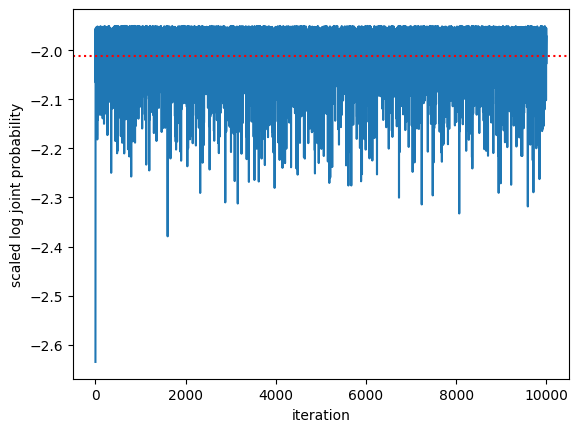

In [21]:
plt.plot(log_probs / num_data)
plt.axhline(log_joint(responses, features, true_weights, prior_scale, noise_dof, noise_scale) / num_data, color='r', ls=':')
plt.xlabel("iteration")
plt.ylabel("scaled log joint probability")

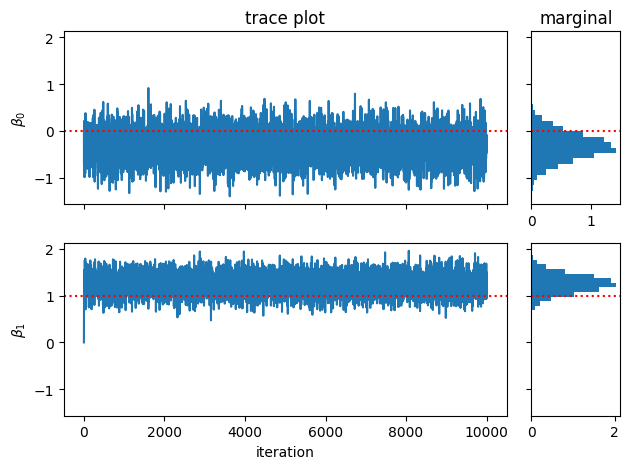

In [22]:
fig, axs = plt.subplots(num_features, 2, width_ratios=(5,1), sharey=True)
for j in range(num_features):
    # Plot the trace of the samples
    axs[j, 0].plot(weight_samples[:, j])
    axs[j, 0].axhline(true_weights[j], color='r', ls=':')
    axs[j, 0].set_ylabel(r"$\beta_{}$".format(j))
    if j < num_features - 1: axs[j,0].set_xticklabels([])

    # Plot a histogram of samples
    axs[j, 1].hist(weight_samples[:, j], 20, orientation="horizontal", density=True)
    axs[j, 1].axhline(true_weights[j], color='r', ls=':')

axs[0, 0].set_title("trace plot")
axs[0, 1].set_title("marginal")
axs[-1,0].set_xlabel("iteration")
plt.tight_layout()

Plot the posterior mean of the weights. Is it any closer to the true weights than the OLS?

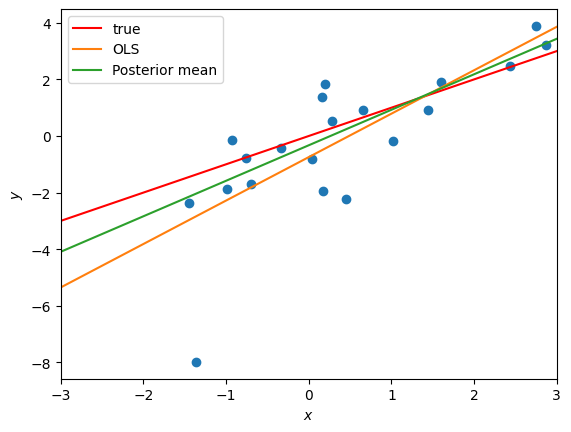

In [23]:
mean_weights = weight_samples.mean(axis=0)
plot_robust_reg_data(responses, features, true_weights,
                     [(ols_weights, "OLS"),
                      (mean_weights, "Posterior mean")])

## Bayesian Probit Regression

There are cool augmentation tricks for Bayesian GLMs too! For example, consider a Bernoulli GLM with the _probit_ link function,
\begin{align*}
f(a) &= \int_{-\infty}^a \mathrm{N}(z ; 0, 1) \, \mathrm{d} z \triangleq \Phi(a),
\end{align*}
i.e., the normal CDF. Like the logistic function, the normal CDF is a monotonically increasing function that defines a bijective mapping from $\mathbb{R} \mapsto (0,1)$. With this mean function, the Bernoulli GLM likelihood is,
\begin{align*}
p(y_i \mid x_i, \beta)
&= \mathrm{Bern}(y_i \mid \Phi(\beta^\top x_i)) \\
&= \Phi(\beta^\top x_i)^{y_i} (1 - \Phi(\beta^\top x_i))^{1 - y_i}.
\end{align*}
{cite:t}`albert1993bayesian` noted that we can rewrite this likelihood using the integral representation of the mean function, together with a few handy transformations. Namely,
\begin{align*}
\Phi(a) = \int_{-\infty}^a \mathrm{N}(z ; 0, 1) \, \mathrm{d} z
&= \int_{0}^\infty \mathrm{N}(z; a, 1) \, \mathrm{d} z,
\end{align*}
\begin{align*}
1 - \Phi(a) &= \int_{-\infty}^0 \mathrm{N}(z; a, 1) \, \mathrm{d} z.
\end{align*}
Substituting these expressions into the likelihood above,
\begin{align*}
p(y_i \mid x_i, \beta)
&= \mathrm{Bern}(y_i \mid \Phi(\beta^\top x_i)) \\
&= \left[\int_{0}^\infty \mathrm{N}(z_i; \beta^\top x_i, 1) \, \mathrm{d} z_i \right]^{y_i} \left[\int_{-\infty}^0 \mathrm{N}(z_i; \beta^\top x_i, 1) \, \mathrm{d} z_i \right]^{1 - y_i} \\
&= \int_{-\infty}^\infty p(y_i \mid z_i) \, \mathrm{N}(z_i \mid \beta^\top x_i, 1) \, \mathrm{d} z_i
\end{align*}
where
\begin{align}
    p(y_i \mid z_i) &=
    \begin{cases}
    \delta_1(y_i) & \text{if } z_i > 0\\
    \delta_0(y_i) & \text{if } z_i \leq 0
    \end{cases}
\end{align}
In other words, we can view the Bernoulli likelihood with probit link as the marginal of a joint distribution, $p(y_i, z_i \mid x_i, \beta)$. In this particular joint distribution, $y_i$ is deterministic given $z_i$.

Another way to think about this augmented model is that we only observe the sign  of a latent variable $z_i$ (where $y_i=0$ if $z_i$ is negative, and $y_i=1$ if it is positive). The latent variable is itself a noisy perturbation of the linear model's prediction, $\beta^\top x_i$. The challenge is, given these observations of the sign, to estimate the underlying weights $\beta$.



### Exercise

1. Show that the conditional distribution of the latent variable $z_i$ in the augmented model is a **truncated normal distribution**.

2. Show that the conditional distribution of the weights given the latent variables $z_i$ is multivariate normal.

3. Implement a Gibbs sampling algorithm to draw samples from the joint distribution $p(z, \beta \mid y, X)$.

## Augmentation Schemes for Bayesian Logistic Regression

We can apply the same logic to the logistic regression case by viewing the logistic function as the CDF of a distribution on the real line. It turns out the corresponding distribution is the aptly named [**logistic distribution**](https://en.wikipedia.org/wiki/Logistic_distribution) with pdf,
\begin{align*}
\mathrm{Logistic}(u; 0, 1) = \frac{\mathrm{d}}{\mathrm{d} u} \sigma(u) = \sigma(u) ( 1 - \sigma(u)) = \frac{e^u}{(1+e^u)^2}.
\end{align*}
Then, we can interpret the Bernoulli likelihood with logistic mean function as a marginal of the auxiliary model,
\begin{align*}
u_i &\sim \mathrm{Logistic}(0, 1) \\
z_i &= x_i^\top \beta + u_i \\
y_i &= \mathbb{I}[z_i > 0].
\end{align*}
Or, as with the probit model above,
\begin{align*}
z_i &\sim \mathrm{Logistic}(x_i^\top \beta, 1) \\
y_i &= \mathbb{I}[z_i > 0].
\end{align*}
The logistic distribution is heavier tailed than a Gaussian. In fact, its is closer to a Student's t distribution with 9 degrees of freedom and slightly inflated scale, as shown below




Text(0, 0.5, '$p(z)$')

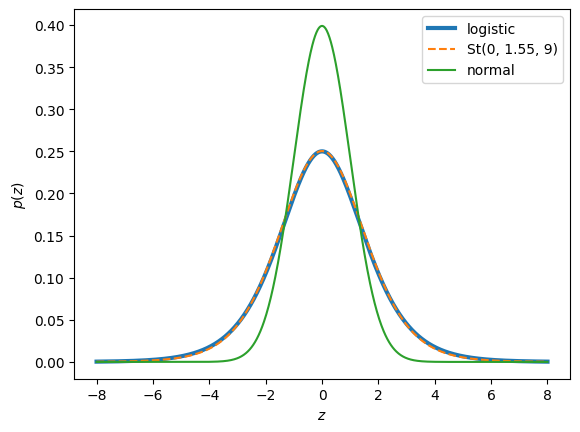

In [24]:
zs = torch.linspace(-8, 8, 1000)
plt.plot(zs, torch.sigmoid(zs) * torch.sigmoid(-zs), lw=3, label="logistic")
plt.plot(zs, torch.exp(StudentT(9, 0, 1.55).log_prob(zs)), '--', label="St(0, 1.55, 9)", )
plt.plot(zs, torch.exp(Normal(0, 1).log_prob(zs)), label="normal")
plt.legend()
plt.xlabel(r"$z$")
plt.ylabel(r"$p(z)$")

This motivates a simple approximation of $z_i \sim \mathrm{St}(9, x_i^\top \beta, 1.55)$. Using this approximation, you can perform Gibbs sampling on the conjugate model, alternating between updating $\beta$ from its Gaussian conditional, and updating $z_i$ from its truncated Student's t conditional.

## Conclusion

This lecture looks works through some actual implementations of MCMC algorithms and develops some useful tricks for Gibbs sampling via augmentation. There are some even better approaches out there for Gibbs sampling in logistic models, and we'll explore them in the homework assignment!